In [1]:
import torch

if torch.cuda.get_device_capability() < (7, 5):
  raise ValueError(f"You got a GPU with capability {torch.cuda.get_device_capability()}, need at least (7, 5)")
else: print("OK")

OK


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%pip install -q bitsandbytes==0.37.0 transformers==4.27.4 datasets==2.7.0 accelerate==0.18.0 loralib==0.1.1 peft==0.3.0.dev0

Note: you may need to restart the kernel to use updated packages.


#### Load model

In [4]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from accelerate import init_empty_weights, infer_auto_device_map

CACHE_DIR = '/media/tfsservices/DATA/NLP/cache/'
MODEL_NAME = "EleutherAI/gpt-neox-20B"


config = AutoConfig.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


In [5]:
device_map = infer_auto_device_map(model, dtype="float16")

In [6]:
# print(device_map)

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,        # bitsandbytes lib required (convert the loaded model into mixed-8bit quantized model.)
    # device_map='auto',
    device_map=device_map,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR)      # path to a directory in which a downloaded pretrained model
    # low_cpu_mem_usage=True,   # loads the model using ~1x model size CPU memory
    # offload_state_dict=True)  # temporarily offload the CPU state dict to the hard drive to avoid getting out of CPU RAM
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 46/46 [00:26<00:00,  1.76it/s]


#### Apply LoRA

In [8]:
# for module in model.modules():
#     if isinstance(module, bnb.nn.Linear8bitLt):
#         module.state.memory_efficient_backward = True

for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
        param.data = param.data.to(torch.float32) # cast the small parameters (e.g. layernorm) to fp32 for stability

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

# cast model outputs to float32 to unfuck the top-k sampler
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
model.embed_out = CastOutputToFloat(model.embed_out)

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [10]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=8, ## can be reduced to 8
    lora_alpha=32,
    target_modules=["query_key_value" ],
    lora_dropout=0.05, ## 0.05
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False # test,
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8650752 || all params: 20563218432 || trainable%: 0.04206905659543013


In [11]:
# model.eval()

#### Methods to calculate perplexity

In [12]:
# %pip install -q nltk spacy
# %pip install -q evaluate


In [13]:
import numpy as np

def get_next_token_prob(lm, prefix, next_token):
    
    batch = tokenizer(prefix, return_tensors='pt') 
    # print(batch) 
    next_token_id = tokenizer(next_token, return_tensors='pt').input_ids[0][0]
    # print(next_token_id)

    return _get_next_token_prob(lm, batch.input_ids, next_token_id)

def _get_next_token_prob(lm, input_ids_prefix, next_token_id):
    probs = []
    with torch.cuda.amp.autocast():
        # outputs = lm.forward(**batch)
        outputs = lm.forward(input_ids=input_ids_prefix)
        probs = outputs.logits[0, -1].softmax(-1)
        # probs = outputs.softmax(-1)

    # print(probs)
    return probs[next_token_id].detach().item()

In [14]:
def get_line_log_prob(lm, prefix, line, min_logprob=np.log(10 ** -50.)):

    input_ids_prefix = tokenizer(prefix, return_tensors='pt').input_ids
    input_ids_line = tokenizer(line, return_tensors='pt').input_ids
    line_log_prob = 0
    
    for _, next_id in enumerate(input_ids_line[0]):
        next_id_unsq = torch.unsqueeze(next_id, dim=-1)
        prob = _get_next_token_prob(lm, input_ids_prefix=input_ids_prefix, 
                                        next_token_id=next_id_unsq)
        if (prob == 0):
            line_log_prob += min_logprob
            continue
        
        log_prob = np.log(prob)
        if (log_prob < min_logprob):
            line_log_prob += min_logprob
            continue
            
        line_log_prob += log_prob
        input_ids_prefix = torch.concat((input_ids_prefix, torch.unsqueeze(next_id_unsq, dim=-1)), 1)

    return line_log_prob

In [15]:
get_line_log_prob(model, "Hi ", ", my name is")


-16.01954630077261

In [16]:
def perplexity(lm, prefix, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above

    """
    corp_log_prob = 0
    
    N = 0
    for line in lines:

        N += len(line.split()) + 1
        line_log_prob = get_line_log_prob(lm, prefix, line, min_logprob)
            
        corp_log_prob += line_log_prob
    
    return np.exp(-corp_log_prob/N) 

In [17]:
# perplexity(model, "Hi", [" my namy is Yury!", ", Jhon.", "! Are you ok?"])

In [18]:
import pandas as pd

# df = pd.read_csv('datasets/armm_large_1.csv')
# df = pd.read_csv('datasets/armm_small.csv')
# df = pd.read_csv('datasets/wm.csv')
# df = pd.read_csv('datasets/wm_large.csv')
# df = pd.read_csv('datasets/wm_large_01.csv')

# df = pd.read_csv('datasets/wm_large_02.csv')
df = pd.read_csv('datasets/armm_large_02.csv')

# CATEGORY = 'Purchase Inquiry'
# CATEGORY = 'Listing Inquiry'

# CATEGORY = 'Requirement'
CATEGORY = 'Listing'


df = df[df['tag']==CATEGORY]

df.head()

,text,tag
0,"{Recipient},\n\nI wanted to show you the below...",Listing
1,"{Recipient},\n\nWe've got the below {Type} com...",Listing
2,"{Recipient},\n\nOne of my clients is releasing...",Listing
3,"{Recipient},\n\nOur client is releasing {Qty} ...",Listing
4,"Dear {Recipient},\n\nGood day. Hope you are do...",Listing


In [19]:
prefix = 'Q: Generate\nA: '

In [20]:
def create_prompt_column(raw):

    # return f"Q: Generate for {raw['tag']}:\nA: {raw['text']}\n###\n"
    # return f"Q: Generate response\nA: {raw['text']}\n###\n"
    return f"{prefix}{raw['text']}\n###\n"

In [21]:
df['prompt'] = df.apply(create_prompt_column, axis=1)

In [22]:
train_dataset_path = './datasets/train.csv'
df.to_csv(train_dataset_path)

In [23]:
df.head()

,text,tag,prompt
0,"{Recipient},\n\nI wanted to show you the below...",Listing,"Q: Generate\nA: {Recipient},\n\nI wanted to sh..."
1,"{Recipient},\n\nWe've got the below {Type} com...",Listing,"Q: Generate\nA: {Recipient},\n\nWe've got the ..."
2,"{Recipient},\n\nOne of my clients is releasing...",Listing,"Q: Generate\nA: {Recipient},\n\nOne of my clie..."
3,"{Recipient},\n\nOur client is releasing {Qty} ...",Listing,"Q: Generate\nA: {Recipient},\n\nOur client is ..."
4,"Dear {Recipient},\n\nGood day. Hope you are do...",Listing,"Q: Generate\nA: Dear {Recipient},\n\nGood day...."


In [24]:
dummy_lines = df[:3]['text']

test_dataset_path = './datasets/test.csv'

df[:3].to_csv(test_dataset_path)

In [25]:
from datasets import load_dataset

# dataset_path = './datasets/wm_ext.csv'

data_files = {"train": train_dataset_path, "test": test_dataset_path}
# dataset = load_dataset("csv", data_files=dataset_path)
dataset = load_dataset("csv", data_files=data_files)
tokenizer.pad_token = tokenizer.eos_token

dataset = dataset.map(lambda samples: tokenizer(samples['prompt']), batched=True)


Using custom data configuration default-20df4b35ed3296c1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting data files #0: 100%|██████████| 1/1 [00:00<00:00, 411.09obj/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dataset csv downloaded and prepared to /home/tfsservices/.cache/huggingface/datasets/csv/default-20df4b35ed3296c1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 356.51ba/s]


In [26]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'tag', 'prompt', 'input_ids', 'attention_mask'],
        num_rows: 123
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'tag', 'prompt', 'input_ids', 'attention_mask'],
        num_rows: 3
    })
})


In [27]:
import evaluate
from transformers import EvalPrediction


def compute_metrics_and_save(p: EvalPrediction):
    
    print("evaluating perplexity...")
    perp = perplexity(model, prefix, dummy_lines)

    num = round(trainer.state.epoch, 1)
    print(f"epoch: {num}")
    print(f"perplexity: {perp}")
    
    adapter_name = f"training/epoch-{num}"
    model.save_pretrained(adapter_name)

    return {'perplexity': perp}

In [28]:
import transformers
from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

trainer = Trainer(
    model=model, 
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    args=TrainingArguments(
        per_device_train_batch_size=4, 
        per_device_eval_batch_size=4, 
        gradient_accumulation_steps=4,
        # warmup_steps=10,
        warmup_ratio=0.25,
        # num_train_epochs=1,
        num_train_epochs=5,
        learning_rate=2e-4, 
        fp16=True,
        evaluation_strategy="epoch",
        # eval_steps=5,
        # evaluation_strategy="steps",
        logging_strategy="steps",
        logging_steps=5,
        output_dir = 'training'
    ),
    
    compute_metrics=compute_metrics_and_save,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False))

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Perplexity
0,3.156800,2.884446,67.905270
1,2.194100,1.975127,23.618940
2,1.869900,1.713199,17.344332
4,1.711500,1.638823,15.625923


evaluating perplexity...
evaluating perplexity...
evaluating perplexity...
evaluating perplexity...
evaluating perplexity...


TrainOutput(global_step=35, training_loss=2.147233145577567, metrics={'train_runtime': 700.0786, 'train_samples_per_second': 0.878, 'train_steps_per_second': 0.05, 'total_flos': 1.0461915796635648e+16, 'train_loss': 2.147233145577567, 'epoch': 4.52})

In [31]:
# trainer.train()
trainer.state.epoch
print(round(trainer.state.epoch,1))

4.5


In [32]:
trainer.state.log_history

[{'loss': 3.1568,
  'learning_rate': 0.00011111111111111112,
  'epoch': 0.65,
  'step': 5},
 {'eval_loss': 2.884445905685425,
  'eval_perplexity': 67.90526982584394,
  'eval_runtime': 65.6303,
  'eval_samples_per_second': 0.046,
  'eval_steps_per_second': 0.015,
  'epoch': 0.9,
  'step': 7},
 {'loss': 2.719,
  'learning_rate': 0.00019230769230769233,
  'epoch': 1.29,
  'step': 10},
 {'loss': 2.1941,
  'learning_rate': 0.00015384615384615385,
  'epoch': 1.94,
  'step': 15},
 {'eval_loss': 1.9751267433166504,
  'eval_perplexity': 23.618940093105916,
  'eval_runtime': 65.5874,
  'eval_samples_per_second': 0.046,
  'eval_steps_per_second': 0.015,
  'epoch': 1.94,
  'step': 15},
 {'loss': 1.8699,
  'learning_rate': 0.00011538461538461538,
  'epoch': 2.58,
  'step': 20},
 {'eval_loss': 1.7131991386413574,
  'eval_perplexity': 17.34433239461534,
  'eval_runtime': 64.4061,
  'eval_samples_per_second': 0.047,
  'eval_steps_per_second': 0.016,
  'epoch': 2.97,
  'step': 23},
 {'loss': 1.7322,
  

In [33]:
train_losses = []
x_train_losses = []

eval_losses = []
x_eval_losses = []

perplexities = []
x_perplexities = []

for data in trainer.state.log_history:
    if ('loss' in data):
        train_losses.append(data['loss'])
        x_train_losses.append(data['epoch'])

    if ('eval_loss' in data):
        eval_losses.append(data['eval_loss'])
        x_eval_losses.append(data['epoch'])

    if ('eval_perplexity' in data):
        perplexities.append(data['eval_perplexity'])
        x_perplexities.append(data['epoch'])

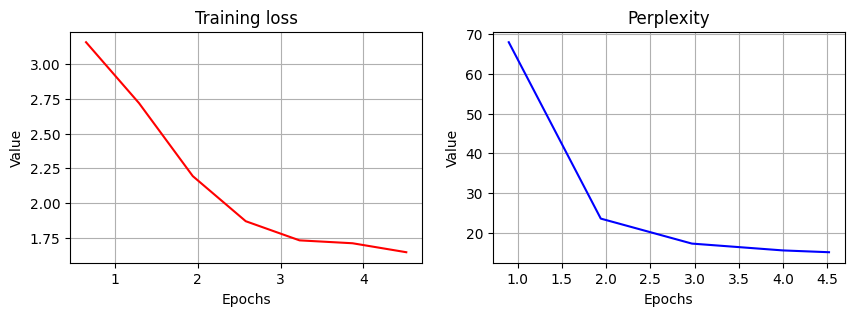

In [34]:
## plot training results
import matplotlib.pyplot as plt

# xdata = np.linspace(1, len(train_losses), len(train_losses))

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,2,1)
ax.plot(x_train_losses, train_losses, color='red')
ax.grid("on")
ax.set_title("Training loss")
ax.set_ylabel("Value")
ax.set_xlabel("Epochs")

ax = fig.add_subplot(1,2,2)
ax.plot(x_perplexities, perplexities, color='blue')
ax.grid("on")
ax.set_title("Perplexity")
ax.set_ylabel("Value")
ax.set_xlabel("Epochs")

plt.show()

In [40]:
# trainer.state.log_history

In [41]:
# import transformers
# from transformers import Trainer, DataCollatorForLanguageModeling, TrainingArguments

# trainer = Trainer(
#     model=model, 
#     train_dataset=dataset['train'],
#     args=TrainingArguments(
#         per_device_train_batch_size=4, 
#         gradient_accumulation_steps=4,
#         # per_device_train_batch_size=1, 
#         # gradient_accumulation_steps=1,
#         warmup_steps=10, 
#         # warmup_steps=2, 
#         # max_steps=20, 
#         # max_steps=10, 
#         # max_steps=43, ## for large dataset
#         # max_steps=40, 
#         max_steps=50, 
#         learning_rate=2e-4, 
#         fp16=True,
#         logging_steps=5, 
#         save_steps=10,
#         output_dir='outputs_wm',
#         overwrite_output_dir=True,
#     ),
#     tokenizer=tokenizer,
#     data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False))

# model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
# trainer.train()

#### Save LoRA adapter

In [46]:
# ADAPTER_NAME = "lora_adapters-6.7b"
# ADAPTER_NAME = "lora_adapters-13b"
# ADAPTER_NAME = "adapters/gpt-j-6B-armm"
# ADAPTER_NAME = "adapters/gpt-j-6B-wm"


# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_purch_resp_fix_02"
# ADAPTER_NAME = "adapters/gpt-neox-20B-wm_list_resp_fix_02"

# ADAPTER_NAME = "adapters/gpt-neox-20B-armm_req"
# ADAPTER_NAME = "adapters/gpt-neox-20B-armm_list"

# ADAPTER_NAME = "adapters/gpt-neox-20B-armm_req_fix_02"
ADAPTER_NAME = "adapters/gpt-neox-20B-armm_list_fix_02"

model.save_pretrained(ADAPTER_NAME)

#### Test generation

In [57]:
# best_epoch = np.argmax(perplexities)
# print(f"best epoch: {best_epoch}")


In [33]:
# from peft import PeftModel, PeftConfig

# # adapter_name = f"training/gpt-neox-20B-wm-purch-resp-{best_epoch}"
# # adapter_name = f"training/gpt-neox-20B-wm-purch-resp-2"
# # adapter_name = f"training/gpt-neox-20B-wm-purch-resp-1"
# adapter_name = f"training/epoch-4.0"
# # model = PeftModel.from_pretrained(model, adapter_name, device_map={"":0})
# model = PeftModel.from_pretrained(model, adapter_name, device_map={"":0})

In [33]:
# model.inference_mode=True
# model.config.use_cache = False

In [44]:
# def generate_text(max_length = 150):
    
#     batch = tokenizer("Q: Generate response\nA: ", return_tensors='pt').to('cuda')

#     # with torch.no_grad():
#     with torch.cuda.amp.autocast():
#         output_tokens = model.generate(**batch, min_length=30, max_length=max_length, do_sample=True, pad_token_id=tokenizer.eos_token_id)

#     print('\n\n', tokenizer.decode(output_tokens[0].cpu().numpy()))

In [35]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = stops
        self.ENCOUNTERS = encounters

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        stop_count = 0
        for stop in self.stops:
            stop_count = (stop == input_ids[0]).sum().item()

        if stop_count >= self.ENCOUNTERS:
            return True
        return False    

stop_words_ids = [tokenizer(stop_word, return_tensors='pt')['input_ids'].squeeze() for stop_word in ["###"]]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids, encounters=1)])

In [36]:
def generate(prompt: str, max_length=250):

    batch = tokenizer(prompt, return_tensors="pt").to('cuda')

    # input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    # with torch.no_grad():
    with torch.cuda.amp.autocast():
        # outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_length=max_length, do_sample=True, )
        outputs = model.generate(**batch,
                                # early_stopping=True, 
                                # num_beams=6,
                                # num_beam_groups = 3,
                                # no_repeat_ngram_size = 4,
                                # temperature=0.9,
                                top_k=10,
                                # top_p=0.8,
                                # penalty_alpha=0.6,
                                # repetition_penalty = 1.05,
                                do_sample=True,

                                max_length = max_length,
                                pad_token_id=tokenizer.eos_token_id,
                                stopping_criteria=stopping_criteria,
                                
                                # use_cachе=True,
                                # output_scores=True,
                                # return_dict_in_generate=True).detach()
        )
        generated = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]
        print(f"tokens: {len(generated.split())}")
        print(f"text: {generated}")

In [37]:
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 78
text: Q: Generate
A: Hello {Recipient},

I am reaching out to you to share an opportunity in one of our clients' tool rooms. The {MakeModel} is still working in the tool shop and has some tools for sale. The shop has a full set of tools in the case. The tools are still in working order except the tool that is for sale. 

Please refer to the photos below. If any questions, just let me know. 

{Specification}

{Signature}
###


In [38]:
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 46
text: Q: Generate
A: Dear {Recipient},

We're looking for a {MakeModel} to sell. This unit has not been used for several years, but it's in good condition.

{Specification}

Please let me know if you are interested or you would like to receive more photos. 

Best,

{Signature}
###


In [39]:
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 171
text: Q: Generate
A: {Recipient},

We are reaching out to you because our client is releasing a number of their {MakeModel} tools in {Timeline} to the market, and the price for the equipment is very reasonable. We have one unit that is in working condition for sale and we would like to sell it as is for {Price} asap for our client's disposal. 

Our client is interested in getting as much equipment in as quick as possible so they can focus their efforts on the upcoming projects.

The equipment you are looking at is the {EquipType}, the system is complete and has never been used. We have no information to release at this time, if you would like a detailed spec you can reach out to me or you can come by and inspect the unit. The seller is not looking to sell their complete system and if you have other equipment you may have in the market they would like to review that as an option as well.

{Specification}

{Signature}
###


In [40]:
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 46
text: Q: Generate
A: Dear {Recipient},

We have this {Type} {MakeModel} {Type} available for sale for {Price}. We believe that this is a good deal and hope that you will consider this.

Here are the pictures and specs of the unit below.

{Specification}

Best regards,

{Signature}
###


In [41]:
generate(prompt='Q: Generate\nA:', max_length=512)

tokens: 62
text: Q: Generate
A: Hello 

We have a client seeking to sell their {Q} {P}, which is {Q}. It is a working {P} {T}, but only for the price of {Price}. They only want to move it quickly to avoid storage costs, because this is only for a client that wants to buy, so it is an immediate need sale. 

{Specification}

{Signature}
###


In [42]:
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 40
text: Q: Generate
A: Dear {Recipient},

We are offering {MakeModel} for sale at {Price} and it is available today.
We are selling this system as-is. Please refer to the photos. It is complete with {EquipPartsList}, {EquipPartsList} and {EquipPartsList}.

{Specification}

{Signature}
###


In [43]:
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 91
text: Q: Generate
A: {Recipient},

We have received a package from a long-time client {MakeModel} with {Qty} {Parts} for sale. This is a very unique and rare package and I hope we can reach an agreement on the price quickly for our client. 

I will be sending photos of the complete system as well as detailed photos of the individual parts in question to you this week so please let me know if you're interested in taking this deal and I will provide all the detailed information. 
Thank you.
{Timeline}

{Signature}
###


In [44]:
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 59
text: Q: Generate
A: Hello {Recipient},

We're selling {Model} in this listing. They were just installed by the supplier and they're ready for immediate transfer. The unit is complete and working as expected. If you are interested in the unit, please get in touch with me as soon as possible so that you can make an evaluation.

{Specification}

{Signature}
###


In [45]:
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 41
text: Q: Generate
A: Dear {Recipient},

Our client has released this {MakeModel} to sell. Please take a look.

{Specification}

The client is looking to sell this system at only {Price}. Please get back to me if you have any questions.

{Signature}
###


In [46]:
generate(prompt="Q: Generate\nA:", max_length=512)

tokens: 79
text: Q: Generate
A: Hi {Recipient},

We have a client that is looking to sell a generator set to help them free up their space. We believe that they have only used this equipment for a month or so to make it available. They are looking to move forward quickly so let's get this done!

The unit is a {MakeModel}, {MakeModelType} and it has {Qty} units available. Please see the detailed photos below. 

{Specification}

{Pictures}

{MakeModelType} {Qty}

Thanks,

{Signature}
###


In [77]:
# generate(prompt="Dear {FirstName} ", max_length=250)
# generate(prompt='Q: Generate for Purchase Inquiry \nA:', max_length=250)

In [78]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [79]:
# generate(prompt="Requirement: Hi {FirstName} ", max_length=200)
# generate(prompt="Requirement: ", max_length=200)
# generate(prompt="Hi {FirstName} ", max_length=250)
# generate(prompt="Q: Generate for Purchase Inquiry \nA: ", max_length=450)

In [80]:
# generate(prompt="Q: Generate for New Listing \nA:", max_length=250)

In [81]:
# generate(prompt="Inquiry: Hi {FirstName} ", max_length=200)